In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import IPython
IPython.core.display.set_matplotlib_formats('retina')
IPython.core.display.display_html(IPython.core.display.HTML("<style>img{image-rendering: pixelated}</style>"))

import numpy as np
from umap import UMAP

from utils.imutil import imread, imshow
from utils.mosaic import make_mosaic, unmake_mosaic
from utils.plot_images import plot_images

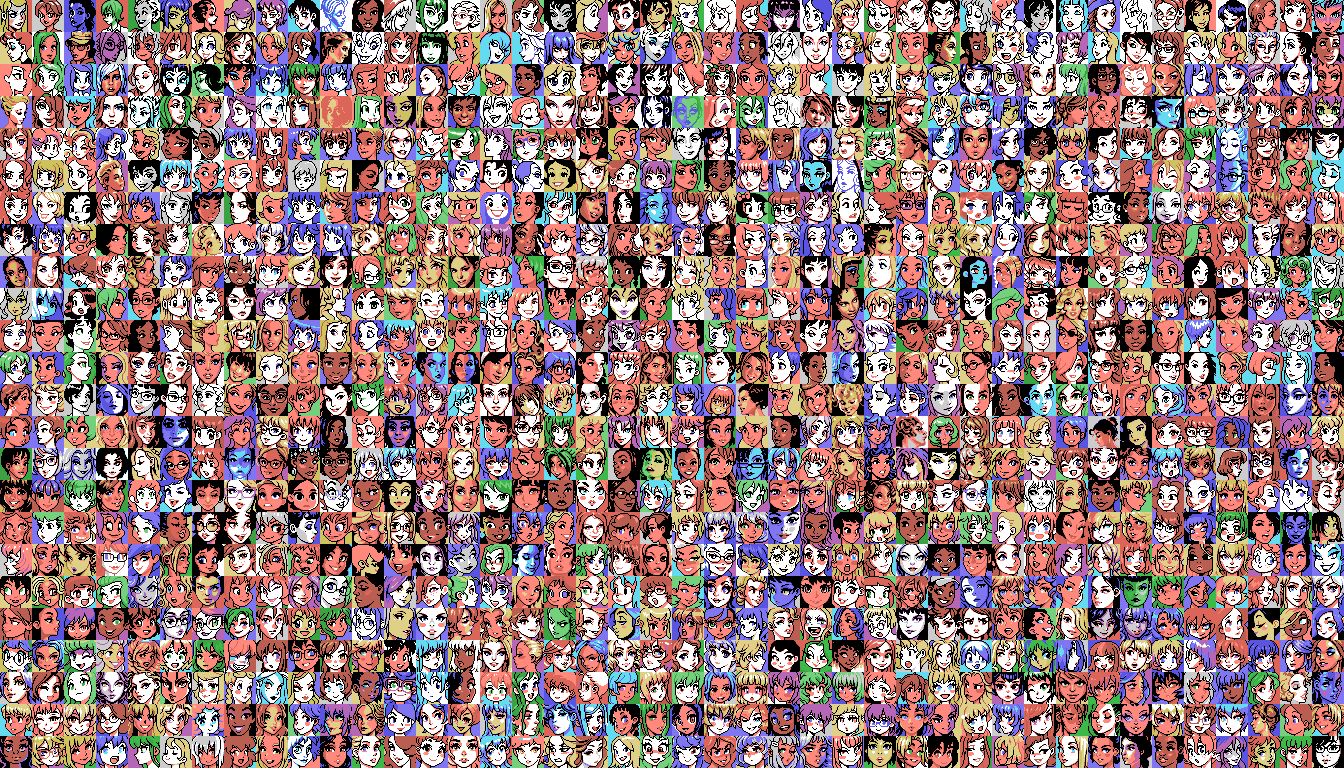

In [2]:
img = imread('img.png', 'rgb')
imshow(img, retina=True)

In [4]:
side = 32
images = unmake_mosaic(img, w=side)
len(images)

1008

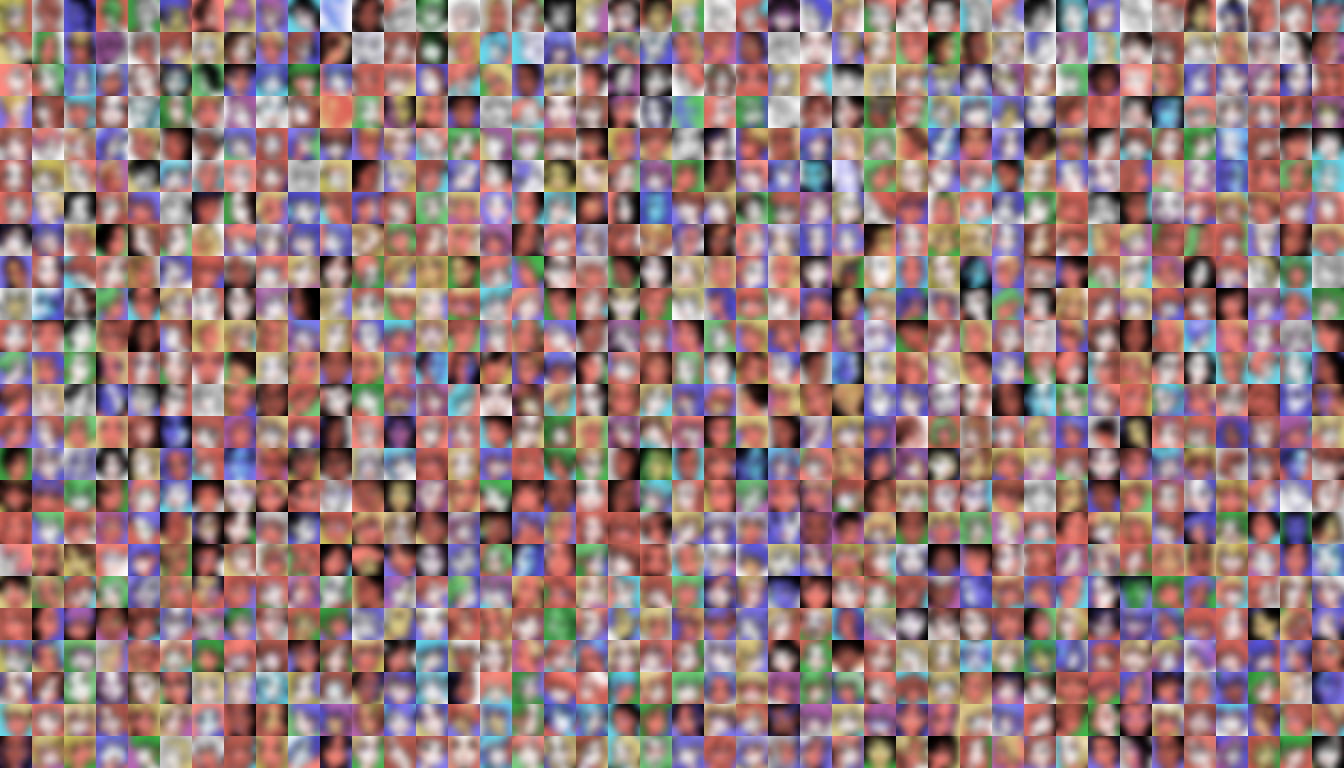

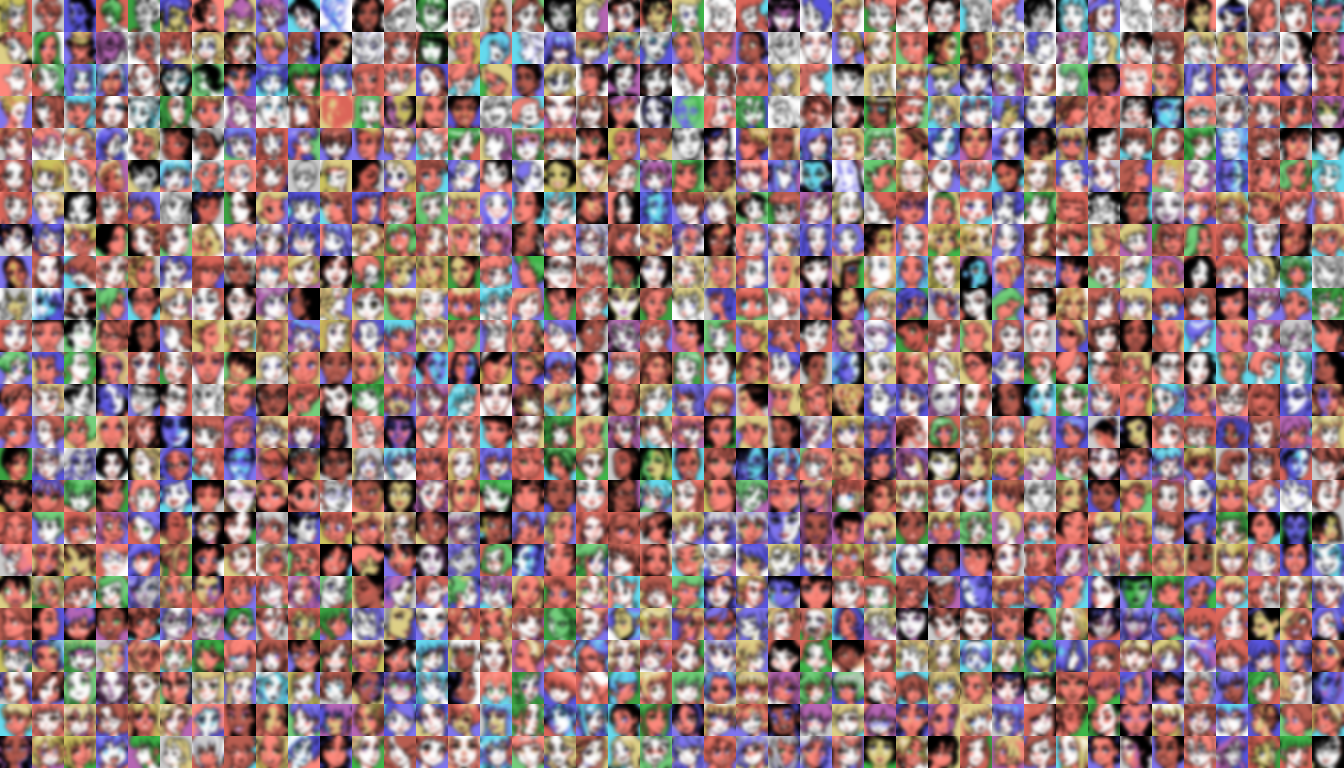

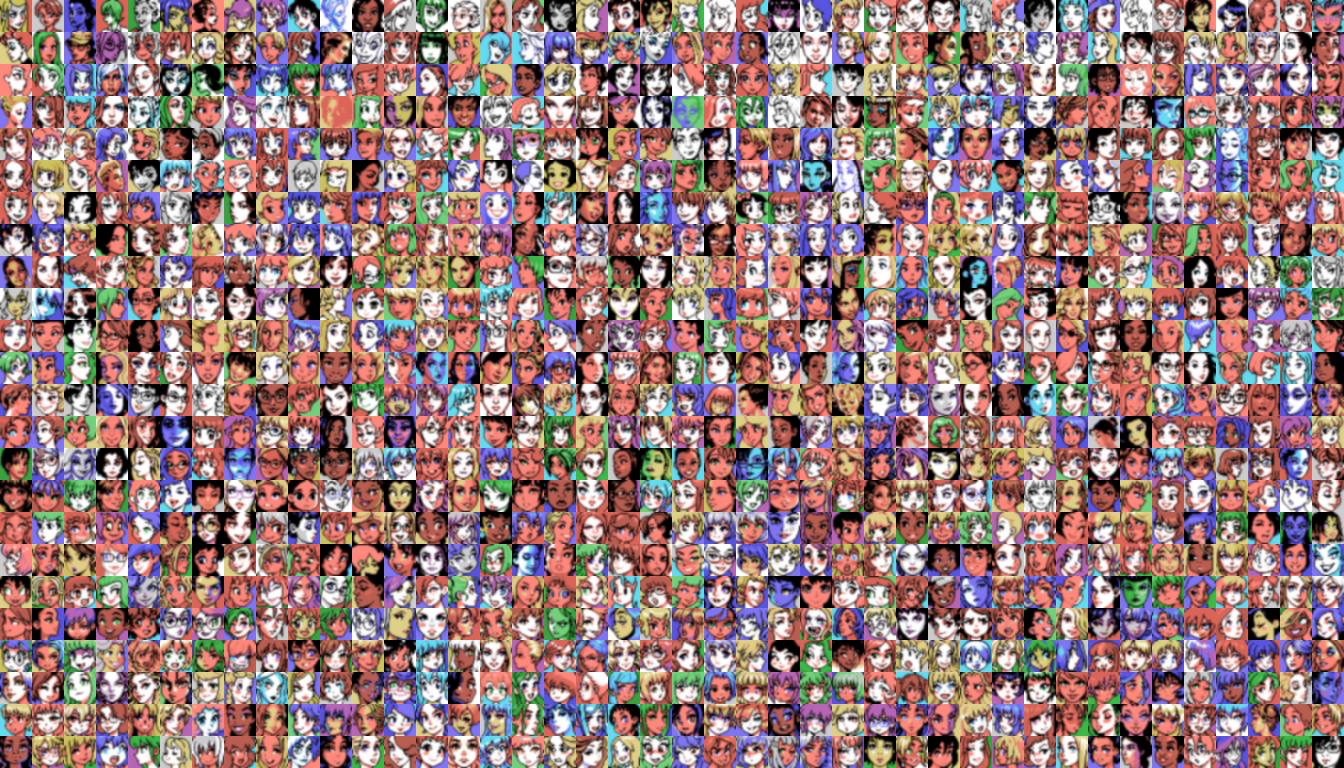

In [5]:
nx = img.shape[1] // side
ny = img.shape[0] // side
blur_levels = [4,2,1]

from skimage.filters import gaussian
def build_blurred(images, sigma):
    blurred = []
    for image in images:
        blurred.append(gaussian(image, sigma=sigma, multichannel=True))
    blurred = np.array(blurred)
    blurred *= 255 / blurred.max()
    return blurred

blurred_0 = build_blurred(images, blur_levels[0])
imshow(make_mosaic(blurred_0, nx=nx, ny=ny), retina=True)

blurred_1 = build_blurred(images, blur_levels[1])
imshow(make_mosaic(blurred_1, nx=nx, ny=ny), retina=True)

blurred_2 = build_blurred(images, blur_levels[2])
imshow(make_mosaic(blurred_2, nx=nx, ny=ny), retina=True)

In [6]:
n = len(images)
pyr = np.hstack((blurred_0.reshape(n, -1),
                 blurred_1.reshape(n, -1),
                 blurred_2.reshape(n, -1),
                 images.reshape(n, -1)))

In [7]:
# source = images
# source = blurred_0
source = pyr
%time Y = UMAP().fit_transform(source.reshape(images.shape[0], -1).astype(np.float64))
Y -= Y.min(axis=0)
Y /= Y.max(axis=0)

CPU times: user 17.9 s, sys: 280 ms, total: 18.1 s
Wall time: 8.99 s


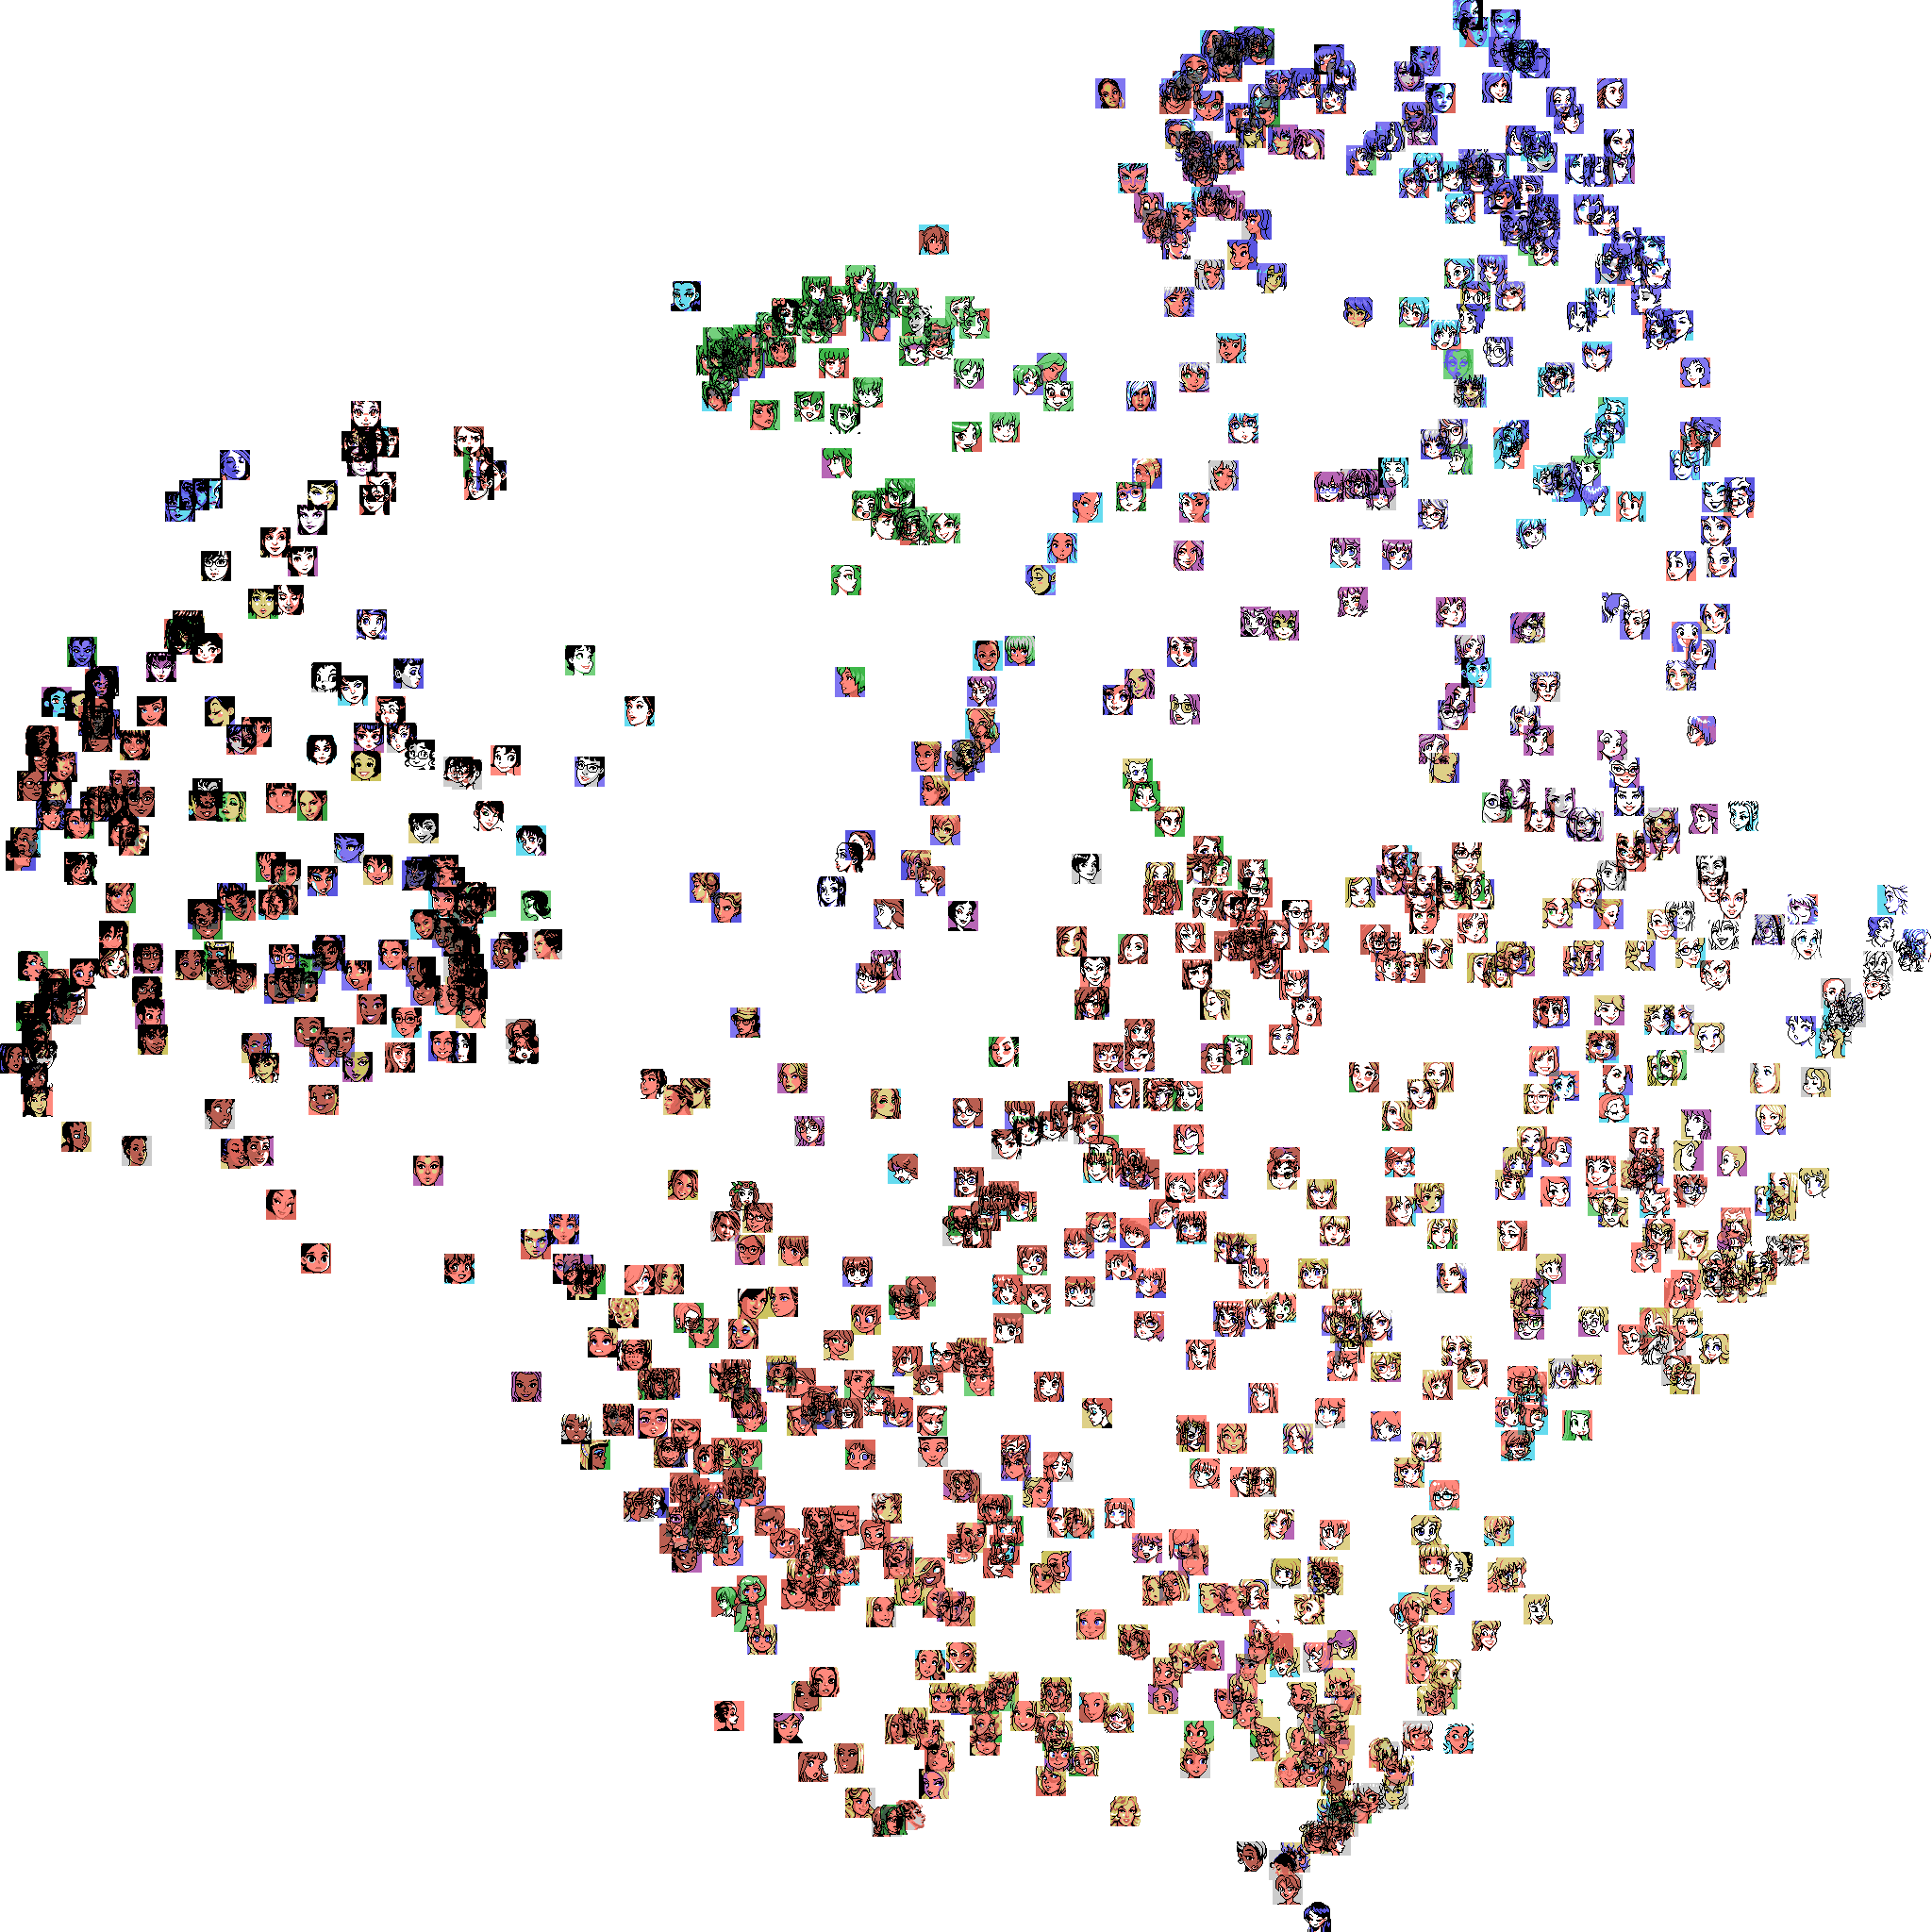

In [8]:
canvas = plot_images(images, Y, canvas_shape=(2048, 2048, 3), blend=np.minimum, fill=255)
imshow(canvas, retina=True)

CPU times: user 1.96 ms, sys: 91 µs, total: 2.05 ms
Wall time: 2.04 ms
CPU times: user 99.9 ms, sys: 0 ns, total: 99.9 ms
Wall time: 99.7 ms


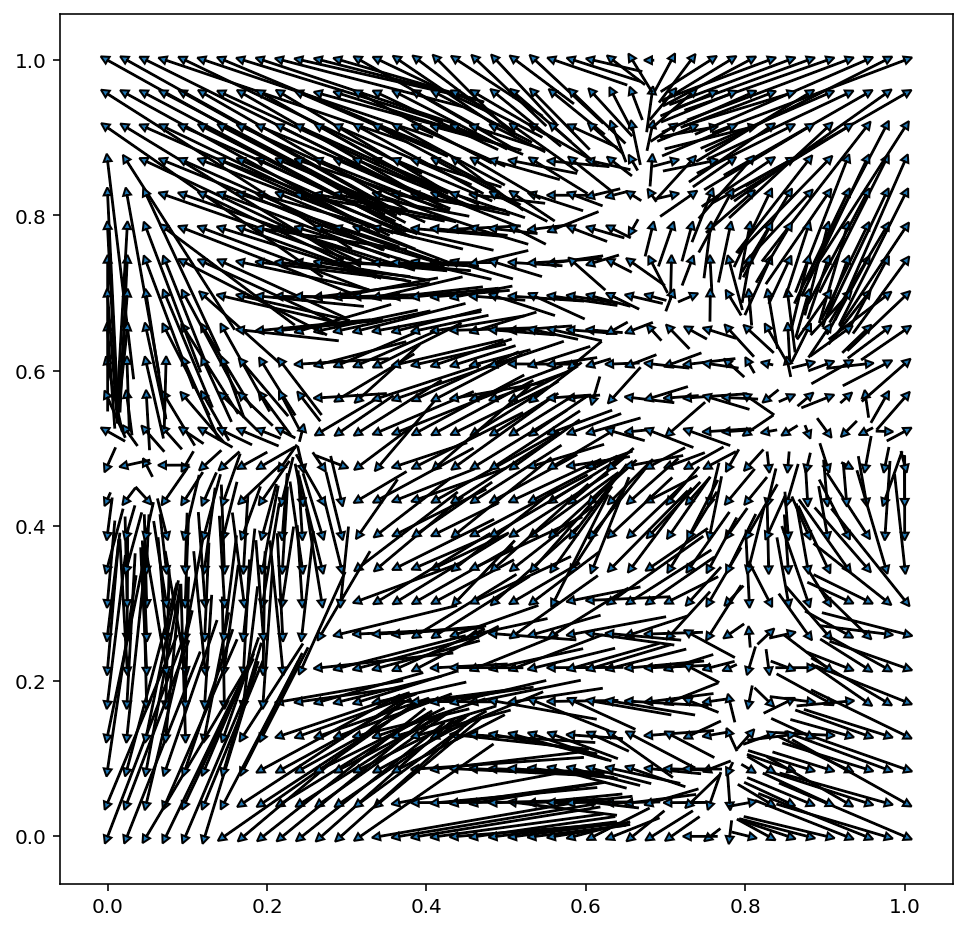

In [9]:
from lap import lapjv
from scipy.spatial.distance import cdist

nx = img.shape[1] // side
ny = img.shape[0] // side
xv, yv = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
grid = np.dstack((xv, yv)).reshape(-1, 2)
%time cost = cdist(grid, Y, 'sqeuclidean')

# use integer costs, or the LAP is much slower
cost = cost * (100000. / cost.max())
cost = cost.astype(int)

totalDataPoints = nx * ny
%time min_cost, row_assigns, col_assigns = lapjv(cost)
grid_jv = grid[col_assigns[:totalDataPoints]]

plt.figure(figsize=(8, 8))
for start, end in zip(Y, grid_jv):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

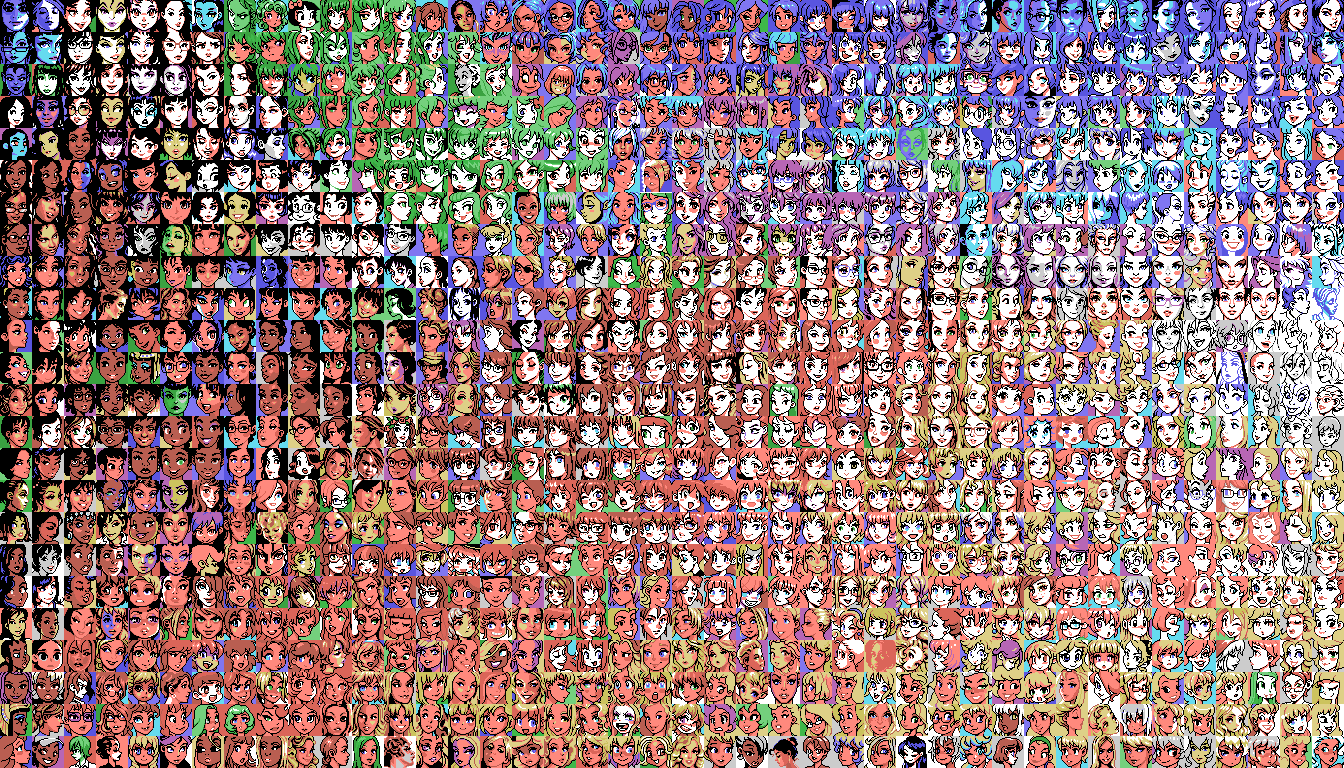

In [10]:
grid_tuples = [(y,x) for (x,y) in map(tuple, grid_jv)]
sorted_images = [image for (point, image) in sorted(zip(grid_tuples, images))]
mosaic = make_mosaic(sorted_images, nx=nx, ny=ny)
imshow(mosaic, retina=True)